Usikkerheden fra støjen på sensoren bestemmes ved standardafvigelsen på målingerne fra nulmålingen.

In [235]:
import numpy as np
import matplotlib.pyplot as plt

# Filstier
nulmåling_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 13 - Harmonisk oscillator\data\nulmåling_lab12.csv"
frimåling_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 13 - Harmonisk oscillator\data\frimåling_lab12.csv"
luftmodstandsmåling_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 13 - Harmonisk oscillator\data\luftmodstandmåling_lab12.csv"
skinnemåling_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 13 - Harmonisk oscillator\data\skinnemåling_lab12.csv"

# Indlæs data
# [s] og [V]
nulmåling = np.genfromtxt(nulmåling_loc, delimiter=",", skip_header=1)
nulmåling_t_arr = nulmåling[:, 0]
nulmåling_v_arr = nulmåling[:, 1]

frimåling = np.genfromtxt(frimåling_loc, delimiter=",", skip_header=1)
frimåling_t_arr = frimåling[:, 0]
frimåling_v_arr = frimåling[:, 1]

luftmodstandsmåling = np.genfromtxt(luftmodstandsmåling_loc, delimiter=",", skip_header=1)
luftmodstandsmåling_t_arr = luftmodstandsmåling[:, 0]
luftmodstandsmåling_v_arr = luftmodstandsmåling[:, 1]

skinnemåling = np.genfromtxt(skinnemåling_loc, delimiter=",", skip_header=1)
skinnemåling_t_arr = skinnemåling[:, 0]
skinnemåling_v_arr = skinnemåling[:, 1]

# Usikkerheden fra signalstøj er standardafvigelsen på vores nulmåling afrundet til første ciffer
# [V]
usikkerhed_signalstøj = round(np.std(nulmåling_v_arr), 3)
usikkerhed_signalstøj

# Usikkerheden på tiden er 
# [s]
usikkerhed_t = 0.000125

Vi plotter vores data (eksklusive nulmålingen) for at se om der er punkter vi ikke skal tage med i fittet

Frimåling


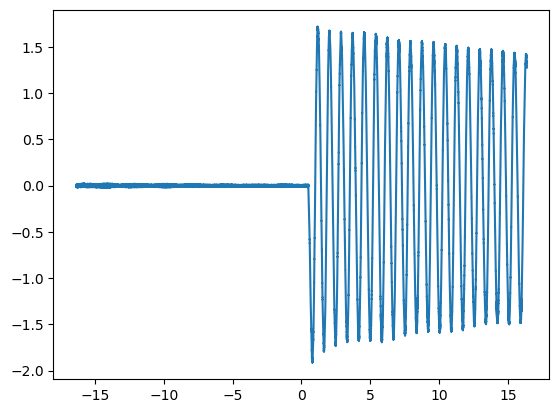

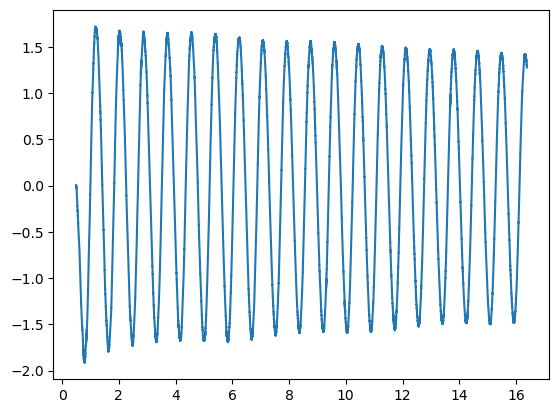

Skinnemåling


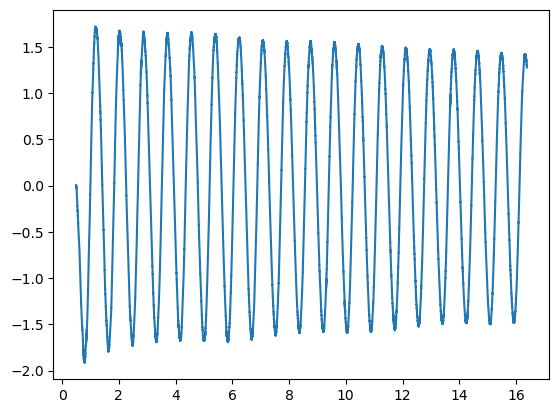

Luftmodstandsmåling


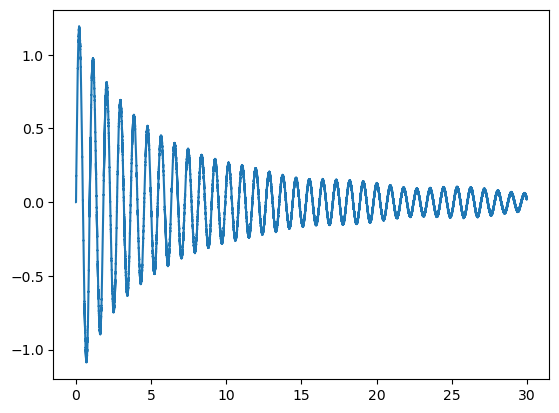

In [236]:
# Plot af data
print("Frimåling")
plt.figure(1)
plt.figsize = (10, 10)
plt.plot(frimåling_t_arr, frimåling_v_arr, label="Frimaling")
plt.show()

# Slet de første 135k punkter fra frimåling
frimåling_t_arr = frimåling_t_arr[135000:]
frimåling_v_arr = frimåling_v_arr[135000:]

plt.figure()
plt.figsize = (10, 10)
plt.plot(frimåling_t_arr, frimåling_v_arr, label="Frimaling")
plt.show()

print("Skinnemåling")
plt.figure()
plt.figsize = (10, 10)
plt.plot(frimåling_t_arr, frimåling_v_arr, label="Frimaling")
plt.show()

print("Luftmodstandsmåling")
plt.figure()
plt.figsize = (10, 10)
plt.plot(luftmodstandsmåling_t_arr, luftmodstandsmåling_v_arr, label="Frimaling")
plt.show()



Vi fitter diverse modeller til datasættet for den udæmpede oscillator.

In [247]:
import sympy as sp
from scipy.optimize import curve_fit

def ingen_dæmp_func(t, A, omega, phi):
    return A*np.sin(omega*t + phi)

def lin_dæmp_func(t, A_0, D, omega, phi):
    return (-1.8 - D*t)*np.sin(omega*t + phi)

def exp_dæmp_func(t, A_0, D, omega, phi):
    return (A_0*np.exp(-D*t))*np.sin(omega*t + phi)



Ingen dæmpning

In [238]:
# Lav fittet
ingen_startgæt = [1.5, 7.8, 5.12885193]
ingen_dæmp_param, ingen_dæmp_cov = curve_fit(ingen_dæmp_func, frimåling_t_arr, frimåling_v_arr, sigma=np.ones(len(frimåling_t_arr))*usikkerhed_signalstøj, absolute_sigma=True, p0=ingen_startgæt)

# Tilføj propageret usikkerhed fra tiden til positionen
A, omega, phi = ingen_dæmp_param

ingen_dæmp_sigma = np.sqrt(np.diagonal(ingen_dæmp_cov))
ingen_dæmp_sigma_prop_u = [(-A*omega*np.sin(omega*t - phi))*usikkerhed_t + usikkerhed_signalstøj for t in frimåling_t_arr]

# Gentag fittet med den propagerede usikkerhed
ingen_dæmp_param, ingen_dæmp_cov = curve_fit(ingen_dæmp_func, frimåling_t_arr, frimåling_v_arr, sigma=ingen_dæmp_sigma_prop_u, absolute_sigma=True, p0=ingen_startgæt)

print(ingen_dæmp_param)

[-1.59904121  7.47642978  8.24373416]


Linær dæmpning

In [249]:
# Lav fittet
lin_startgæt = [-1.8        -0.09077228  8.02426903  2.34945527]

lin_dæmp_param, lin_dæmp_cov = curve_fit(lin_dæmp_func, luftmodstandsmåling_t_arr, luftmodstandsmåling_v_arr, sigma=np.ones(len(luftmodstandsmåling_t_arr))*usikkerhed_signalstøj, absolute_sigma=True ,p0=lin_startgæt, maxfev=100000)

# Tilføj propageret usikkerhed fra tiden til positionen
A_0, D, omega, phi = lin_dæmp_param

lin_dæmp_sigma = np.sqrt(np.diagonal(lin_dæmp_cov))
lin_dæmp_sigma_prop_u = [(-D - (A_0 - D*t)*omega*np.sin(omega*t - phi))*usikkerhed_t + usikkerhed_signalstøj for t in luftmodstandsmåling_t_arr]

# Gentag fittet med den propagerede usikkerhed
lin_dæmp_param, lin_dæmp_cov = curve_fit(lin_dæmp_func, luftmodstandsmåling_t_arr, luftmodstandsmåling_v_arr, sigma=lin_dæmp_sigma_prop_u, absolute_sigma=True, p0=lin_startgæt, maxfev=100000)

print(lin_dæmp_param)

[-1.8        -0.09077228  8.02426903  2.34945527]


Eksponentiel dæmpning

In [240]:
# Lav fittet
exp_startgæt = [-1.5, 1, 7.48253038, 1]
exp_dæmp_param, exp_dæmp_cov = curve_fit(exp_dæmp_func, skinnemåling_t_arr, skinnemåling_v_arr, sigma=np.ones(len(skinnemåling_t_arr))*usikkerhed_signalstøj, absolute_sigma=True, p0=exp_startgæt)

# Tilføj propageret usikkerhed fra tiden til positionen
A_0, D, omega, phi = exp_dæmp_param

exp_dæmp_sigma = np.sqrt(np.diagonal(exp_dæmp_cov))
exp_dæmp_prop_u = [(-D*t*A_0*np.exp(-D*t) - A_0*np.exp(-D*t)*np.sin(omega*t - phi))*usikkerhed_t + usikkerhed_signalstøj for t in skinnemåling_t_arr]

# Gentag fittet med den propagerede usikkerhed
exp_dæmp_param, exp_dæmp_cov = curve_fit(exp_dæmp_func, skinnemåling_t_arr, skinnemåling_v_arr, sigma=exp_dæmp_prop_u, absolute_sigma=True, p0=exp_startgæt)

print(exp_dæmp_param)

[1.77351577e+00 7.68574374e-02 7.48253021e+00 5.32726125e-03]


Vi plotter fitsne sammen med vores data for den udæmpede oscillator

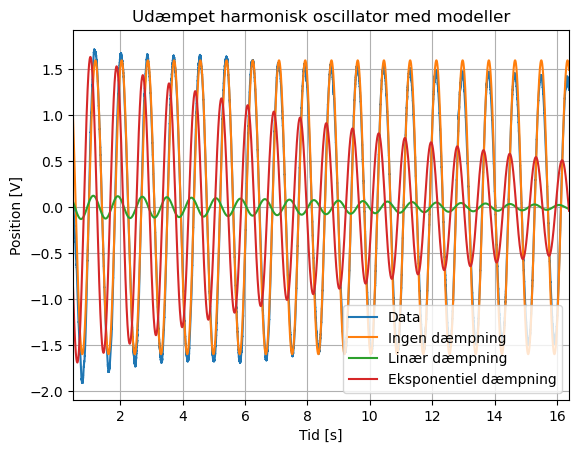

In [246]:
# Plot af data
plt.figure(1)
plt.grid()
plt.xlabel("Tid [s]")
plt.ylabel("Position [V]")
plt.title("Udæmpet harmonisk oscillator med modeller")
plt.plot(frimåling_t_arr, frimåling_v_arr, label="Data")
plt.plot(frimåling_t_arr, ingen_dæmp_func(frimåling_t_arr, *ingen_dæmp_param), label="Ingen dæmpning")
plt.plot(luftmodstandsmåling_t_arr, lin_dæmp_func(luftmodstandsmåling_t_arr, *lin_dæmp_param), label="Linær dæmpning")
plt.plot(skinnemåling_t_arr, exp_dæmp_func(skinnemåling_t_arr, *exp_dæmp_param), label="Eksponentiel dæmpning")
plt.gca().set_xlim([min(frimåling_t_arr), max(frimåling_t_arr)])
plt.legend()
plt.show()
